In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import sys
sys.path.append("/home/z5297792/UNSW-MRes/MRes/modules") 
from utils import plot_ellipse, moca

import re
def extract_number(s):
    match = re.search(r'\d+', s)
    return int(match.group()) if match else None


In [2]:
def find_root(x, y):
    coeffs = np.polyfit(x, y, 3)
    roots = np.roots(np.poly1d(coeffs))
    real_roots = roots[np.isreal(roots)].real
    mid = x[len(x)//2]
    return real_roots[np.argmin(np.abs(mid - real_roots))]

def tang_at_root(x, y, rx):
    coeffs = np.polyfit(x, y, 3)
    deriv = np.polyder(coeffs)
    slope = np.polyval(deriv, rx)
    intercept = np.polyval(coeffs, rx) - slope * rx
    return slope, intercept

def cubic_interpolate(x, y, root):
    coeffs = np.polyfit(x, y, 3)
    return np.polyval(coeffs, root)

In [3]:
width=500
x = np.linspace(-width // 2, width // 2, 101)
y = np.linspace(-width // 2, width // 2, 101)
X, Y = np.meshgrid(x, y, indexing='ij')
psi0 = 210
Rc = 4
xc, yc = 0, 0 
q11, q12, q22 = .002, 0.0, .002

rhox = 2*q11*(X-xc) + 2*q12*(Y-yc)
rhoy = 2*q22*(Y-yc) + 2*q12*(X-xc)
rho = q11*(X-xc)**2 + q12*(X-xc)*(Y-yc) + q22*(Y-yc)**2

u =  psi0/Rc**2 * rhoy * np.exp(-1/Rc**2 * rho)
v = -psi0/Rc**2 * rhox * np.exp(-1/Rc**2 * rho)


In [4]:
nic, njc = 50, 60
r = 14

df_tests = pd.DataFrame({
    'nic': [nic, nic, nic, nic, nic, nic],
    'njc': [54, njc, 66, njc, njc, njc],
    'r': [r, r, r, 8, r, 20]
}, index=['P1', 'P2', 'P3', 'L1', 'L2', 'L3'])

dic_tests = {}
df_res = pd.DataFrame(columns=['xc', 'yc', 'w', 'Q', 'Rc', 'psi0'])
for test in df_tests.index:
    data = df_tests.loc[test]

    x1 = x[data.nic-data.r:data.nic+data.r+1]
    y1 = np.array([y[data.njc]] * len(x1))
    l = x1 - x1[0]
    
    u1 = u[data.nic-data.r:data.nic+data.r+1, data.njc]
    v1 = v[data.nic-data.r:data.nic+data.r+1, data.njc]

    l0, r0, w, Q, Rc, psi0, q = moca(l, u1, v1)
    xc, yc = l0 + x1[0], r0 + y1[0]
    
    dic_tests[test] = {'x1': x1, 'y1': y1, 'l': l, 'u1': u1, 'v1': v1, 'name': test}
    df_res.loc[len(df_res)] = {'xc': xc, 'yc': yc, 'w': w, 'Q': Q, 'Rc': Rc, 'psi0': psi0}
df_res.index = df_tests.index
df_res


/home/z5297792/UNSW-MRes/MRes/modules/utils.py:385: RuntimeWarning: overflow encountered in exp
  exp_t = np.exp(-rho/Rc**2)
/home/z5297792/UNSW-MRes/MRes/modules/utils.py:385: RuntimeWarning: overflow encountered in exp
  exp_t = np.exp(-rho/Rc**2)


,xc,yc,w,Q,Rc,psi0
P1,-7.105427e-14,-0.502329,-0.096021,"[[-0.024005285850665463, 0.0], [0.0, -0.024005...",3.084901,238.363601
P2,-5.684342e-14,-1.255822,-0.073852,"[[-0.018463098231950623, 0.0], [0.0, -0.018463...",2.722571,331.107000
P3,0.000000e+00,-2.009316,-0.045357,"[[-0.011339294124841493, 0.0], [0.0, -0.011339...",1.995575,418.171642
L1,0.000000e+00,-0.165836,-0.076417,"[[-0.01910417599526519, 0.0], [0.0, -0.0191041...",1.594328,681.909828
L2,-5.684342e-14,-1.255822,-0.073852,"[[-0.018463098231950623, 0.0], [0.0, -0.018463...",2.722571,331.107000
L3,8.526513e-14,-4.216860,-0.067532,"[[-0.016882955720721068, 0.0], [0.0, -0.016882...",3.613376,256.113684


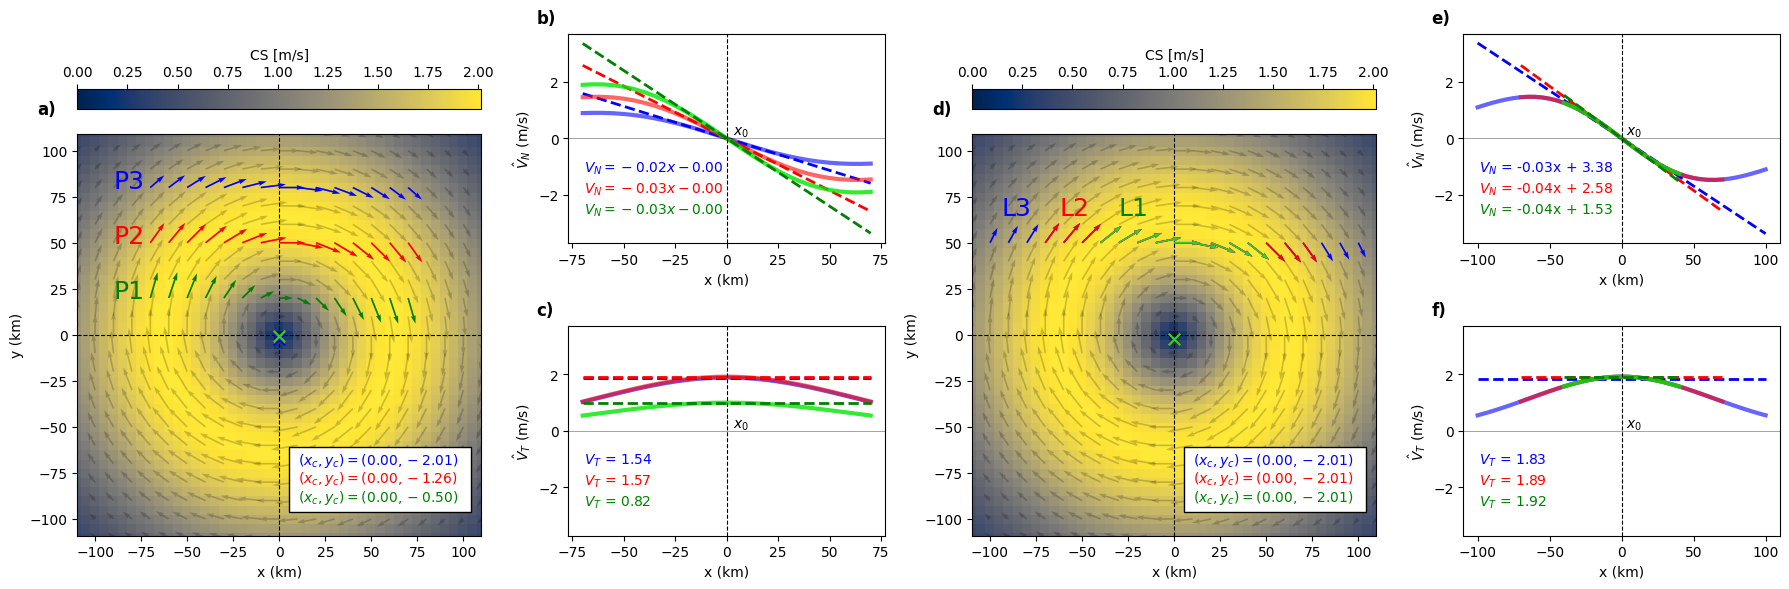

In [6]:
from matplotlib.patches import Rectangle
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(18, 6))
gs = gridspec.GridSpec(2, 6, figure=fig, width_ratios=[1, 1, 2, 1, 1, 2])  # Adjust width ratios

# LEFT PLOT (PLOT A)
ax_main_left = fig.add_subplot(gs[:, :2])
pc = ax_main_left.pcolor(x, y, np.hypot(u, v), cmap='cividis')
plt.colorbar(pc, ax=ax_main_left, orientation='horizontal', location='top', label='CS [m/s]')
ax_main_left.axhline(0, color='black', linewidth=0.8, linestyle='--', zorder=2)
ax_main_left.axvline(0, color='black', linewidth=0.8, linestyle='--', zorder=2)

spacing = 2
scale = 30
width = 0.004
alpha = 1
quiv = ax_main_left.quiver(x[::spacing], y[::spacing], u[::spacing, ::spacing].T, v[::spacing, ::spacing].T, alpha=.2, scale=scale, width=width)

colors = ['limegreen', 'r', 'b']
color = ['g', 'r', 'b']
color_fits = [(0, .9, 0, 0.8), (1, 0, 0, 0.6), (0, 0, 1, 0.6)]
i = 0
for dic in dic_tests.values():
    if 'P' in dic['name']:
        x1, y1, l, u1, v1 = dic['x1'], dic['y1'], dic['l'], dic['u1'], dic['v1']
        data = df_res.loc[dic['name']]
        
        # if dic['name'] == 'P2':
        #     # l axis
        #     ax_main_left.quiver(x1[0], y1[0], x1[-1] - x1[0] + 20, y1[-1] - y1[0], angles='xy', scale_units='xy', scale=1, color='k', width=0.003, zorder=1)
        #     ax_main_left.plot([x1[0], x1[0]], [y1[0] - 10, y1[0] + 10], color='k', linewidth=1)
        #     ax_main_left.text(x1[-1] + 20, y1[0], r'$\ell$', fontsize=18)
        ax_main_left.text(x1[0]-20, y1[0], dic['name'], color=color[i], zorder=3, fontsize=18)
        ax_main_left.quiver(x1[::spacing], y1[::spacing], u1[::spacing], v1[::spacing], scale=scale, width=width, color=color[i], zorder=3)
        ax_main_left.scatter(data.xc, data.yc, color=colors[i], marker='x', s=70, zorder=10-extract_number(dic['name']))
        ax_main_left.text(10, -90 + 10*i, fr'$(x_c,y_c)=({np.abs(data.xc):.2f},{data.yc:.2f})$', color=color[i])
        i += 1
        
x_pos, y_pos = 0.75, 0.14
box_width = 0.45  # Adjust width as needed
box_height = 0.16 #0.07  # Adjust height as needed
rect = Rectangle((x_pos - box_width / 2, y_pos - box_height / 2), 
                       box_width, box_height, transform=ax_main_left.transAxes,
                       facecolor='white', edgecolor='black')
ax_main_left.add_patch(rect)
ax_main_left.axis('equal')
ax_main_left.set_xlim(-100, 100)
ax_main_left.set_ylim(-100, 100)
ax_main_left.set_xlabel('x (km)')
ax_main_left.set_ylabel('y (km)')
ax_main_left.text(-0.1, 1.05, 'a)', transform=ax_main_left.transAxes, fontsize=12, fontweight='bold')

# Subplot columns (2x1 on the right)
ax2_left = fig.add_subplot(gs[0, 2])
ax3_left = fig.add_subplot(gs[1, 2])

# color_fits = [(0, 1, 0, 0.6), (1, 0, 0, 0.6), (0, 0, 1, 0.6)]
j = 0
for dic in dic_tests.values():
    if 'P' in dic['name']:
        x1, y1, l, u1, v1 = dic['x1'], dic['y1'], dic['l'], dic['u1'], dic['v1']

        fit = np.poly1d(np.polyfit(x1, v1, 1))

        root = find_root(x1, v1)
        c, b = tang_at_root(x1, v1, root)
        a = cubic_interpolate(x1, u1, root)

        p_v1 = c*x1 + b
        p_u1 = [a]*len(x1)

        ax2_left.plot(x1, v1, color=color_fits[j], linewidth=3, zorder=-extract_number(dic['name']))
        ax2_left.plot(x1, p_v1, color=color[j], linestyle='--', linewidth=2, zorder=-extract_number(dic['name']))
        # ax2_left.text(0.05, 0.2 + 0.1 * j, fr"$\widetilde{{v}}$ = {fit[1]:.2f}$\ell$ + {fit[0]:.2f}", transform=ax2_left.transAxes,
        #  fontsize=10, verticalalignment='top', color=color[j])
        ax2_left.text(0.05, 0.2 + 0.1 * j, fr"$V_N={fit[1]:.2f}x{'+' if fit[0]>0 else ''}{fit[0]:.2f}$", transform=ax2_left.transAxes,
         fontsize=10, verticalalignment='top', color=color[j])

        fit = np.poly1d(np.polyfit(x1, u1, 0))
        ax3_left.plot(x1, u1, color=color_fits[j], linewidth=3, zorder=-extract_number(dic['name']))
        ax3_left.plot(x1, p_u1, color=color[j], linestyle='--', linewidth=2, zorder=-extract_number(dic['name']))
        # ax3_left.text(0.05, 0.2 + 0.1 * j, fr"$\widetilde{{u}}$ = {fit[0]:.2f}", transform=ax3_left.transAxes,
        #  fontsize=10, verticalalignment='top', color=color[j])
        ax3_left.text(0.05, 0.2 + 0.1 * j, fr"$V_T$ = {fit[0]:.2f}", transform=ax3_left.transAxes,
         fontsize=10, verticalalignment='top', color=color[j])

        j += 1

ax2_left.text(3, .13, r'$x_0$')
ax3_left.text(3, .13, r'$x_0$')
        
ax2_left.axvline(x1[len(x1) // 2], color='black', linewidth=0.8, linestyle='--', zorder=2)
ax2_left.axhline(y=0, color='k', zorder=-1, linewidth=.5, alpha=.5)
ax2_left.set_ylabel(r'$\hat{V}_N$ (m/s)')
ax2_left.set_xlabel('x (km)')
ax2_left.text(-0.1, 1.05, 'b)', transform=ax2_left.transAxes, fontsize=12, fontweight='bold')
ax3_left.axvline(x1[len(x1) // 2], color='black', linewidth=0.8, linestyle='--', zorder=2)
ax3_left.axhline(y=0, color='k', zorder=-1, linewidth=.5, alpha=.5)
ax3_left.set_ylabel(r'$\hat{V}_T$ (m/s)')
ax3_left.set_xlabel('x (km)')
ax3_left.text(-0.1, 1.05, 'c)', transform=ax3_left.transAxes, fontsize=12, fontweight='bold')

# Right PLOT (PLOT B)
ax_main_right = fig.add_subplot(gs[:, 3:5])
pc = ax_main_right.pcolor(x, y, np.hypot(u, v), cmap='cividis')
plt.colorbar(pc, ax=ax_main_right, orientation='horizontal', location='top', label='CS [m/s]')
ax_main_right.axhline(0, color='black', linewidth=0.8, linestyle='--', zorder=2)
ax_main_right.axvline(0, color='black', linewidth=0.8, linestyle='--', zorder=2)
quiv = ax_main_right.quiver(x[::spacing], y[::spacing], u[::spacing, ::spacing].T, v[::spacing, ::spacing].T, alpha=.2, scale=scale, width=width)

i = 0
for dic in dic_tests.values():
    if 'L' in dic['name']:
        x1, y1, l, u1, v1 = dic['x1'], dic['y1'], dic['l'], dic['u1'], dic['v1']
        ax_main_right.quiver(x1[::spacing], y1[::spacing], u1[::spacing], v1[::spacing], scale=scale, width=width, color=colors[i], zorder=5-i)
        ax_main_right.scatter(data.xc, data.yc, color=colors[i], marker='x', s=70, zorder=10-extract_number(dic['name']))
        ax_main_right.text(10, -90 + 10*i, fr'$(x_c,y_c)=({np.abs(data.xc):.2f},{data.yc:.2f})$', color=color[i])

        ax_main_right.text(x1[0]-i*2 +10, y1[0]+15, dic['name'], color=color[i], zorder=3, fontsize=18)
 
        i += 1
x_pos, y_pos = 0.75, 0.14
box_width = 0.45  # Adjust width as needed
box_height = 0.16 #0.07  # Adjust height as needed
rect = Rectangle((x_pos - box_width / 2, y_pos - box_height / 2), 
                       box_width, box_height, transform=ax_main_right.transAxes,
                       facecolor='white', edgecolor='black')
ax_main_right.add_patch(rect)
ax_main_right.axis('equal')
ax_main_right.set_xlim(-100, 100)
ax_main_right.set_ylim(-100, 100)
ax_main_right.set_xlabel('x (km)')
ax_main_right.set_ylabel('y (km)')
ax_main_right.text(-0.1, 1.05, 'd)', transform=ax_main_right.transAxes, fontsize=12, fontweight='bold')

# Subplot columns (2x1 on the right)
ax2_right = fig.add_subplot(gs[0, 5])
ax3_right = fig.add_subplot(gs[1, 5])

j = 0
for dic in dic_tests.values():
    if 'L' in dic['name']:
        x1, y1, l, u1, v1 = dic['x1'], dic['y1'], dic['l'], dic['u1'], dic['v1']
        
        root = find_root(l, v1)
        c, b = tang_at_root(l, v1, root)
        a = cubic_interpolate(l, u1, root)

        # just for label
        # ax2_right.text(0.05, 0.2 + 0.1 * j, fr"$\widetilde{{v}}$ = {c:.2f}$\ell$ + {b:.2f}", transform=ax2_right.transAxes,
        #  fontsize=10, verticalalignment='top', color=color[j])
        # ax3_right.text(0.05, 0.2 + 0.1 * j, fr"$\widetilde{{u}}$ = {a:.2f}", transform=ax3_right.transAxes,
        #  fontsize=10, verticalalignment='top', color=color[j])
        ax2_right.text(0.05, 0.2 + 0.1 * j, fr"$V_N$ = {c:.2f}x + {b:.2f}", transform=ax2_right.transAxes,
         fontsize=10, verticalalignment='top', color=color[j])
        ax3_right.text(0.05, 0.2 + 0.1 * j, fr"$V_T$ = {a:.2f}", transform=ax3_right.transAxes,
         fontsize=10, verticalalignment='top', color=color[j])

        l_big = dic_tests['L3']['l']
        l = l + .5 * np.abs(l_big[-1] - l[-1])

        root = find_root(x1, v1)
        c, b = tang_at_root(x1, v1, root)
        a = cubic_interpolate(x1, u1, root)

        p_v1 = c*x1 + b
        p_u1 = [a]*len(x1)

        ax2_right.plot(x1, v1, color=color_fits[j], linewidth=3, zorder=-extract_number(dic['name']))
        ax2_right.plot(x1, p_v1, color=color[j], linestyle='--', linewidth=2, zorder=-extract_number(dic['name']))

        ax3_right.plot(x1, u1, color=color_fits[j], linewidth=3, zorder=-extract_number(dic['name']))
        ax3_right.plot(x1, p_u1, color=color[j], linestyle='--', linewidth=2, zorder=-extract_number(dic['name']))

        j += 1

ax2_right.text(3, .13, r'$x_0$')
ax3_right.text(3, .13, r'$x_0$')

ax2_right.axvline(x1[len(x1) // 2], color='black', linewidth=0.8, linestyle='--', zorder=2)
ax2_right.axhline(y=0, color='k', zorder=-1, linewidth=.5, alpha=.5)
ax2_right.set_ylabel(r'$\hat{V}_N$ (m/s)')
ax2_right.text(-0.1, 1.05, 'e)', transform=ax2_right.transAxes, fontsize=12, fontweight='bold')
ax2_right.set_xlabel('x (km)')
# ax2_right.set_xticks([])
ax3_right.axvline(x1[len(x1) // 2], color='black', linewidth=0.8, linestyle='--', zorder=2)
ax3_right.axhline(y=0, color='k', zorder=-1, linewidth=.5, alpha=.5)
ax3_right.set_ylabel(r'$\hat{V}_T$ (m/s)')
ax3_right.set_xlabel('x (km)')
ax3_right.text(-0.1, 1.05, 'f)', transform=ax3_right.transAxes, fontsize=12, fontweight='bold')
ax3_right.set_xlabel('x (km)')
# ax3_right.set_xticks([])

axs = [ax2_left, ax3_left, ax2_right, ax3_right]
ymin, ymax = np.inf, -np.inf
for ax in axs:
    ymin = min(ymin, ax.get_ylim()[0])
    ymax = max(ymax, ax.get_ylim()[1])

for ax in axs:
    ax.set_ylim(ymin, ymax)

plt.tight_layout()
plt.show()


In [7]:
df_res

,xc,yc,w,Q,Rc,psi0
P1,-7.105427e-14,-0.502329,-0.096021,"[[-0.024005285850665463, 0.0], [0.0, -0.024005...",3.084901,238.363601
P2,-5.684342e-14,-1.255822,-0.073852,"[[-0.018463098231950623, 0.0], [0.0, -0.018463...",2.722571,331.107000
P3,0.000000e+00,-2.009316,-0.045357,"[[-0.011339294124841493, 0.0], [0.0, -0.011339...",1.995575,418.171642
L1,0.000000e+00,-0.165836,-0.076417,"[[-0.01910417599526519, 0.0], [0.0, -0.0191041...",1.594328,681.909828
L2,-5.684342e-14,-1.255822,-0.073852,"[[-0.018463098231950623, 0.0], [0.0, -0.018463...",2.722571,331.107000
L3,8.526513e-14,-4.216860,-0.067532,"[[-0.016882955720721068, 0.0], [0.0, -0.016882...",3.613376,256.113684
